In [412]:
from math import pi
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit import ParameterVector
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.algorithms.optimizers import SPSA, POWELL

In [413]:
numx       = 3
numq       = 3
num_layers = 2
numtheta   = numq*(num_layers+3)
num_out    = 1
num_in     = 2**numq

x          = ParameterVector('x', numx)

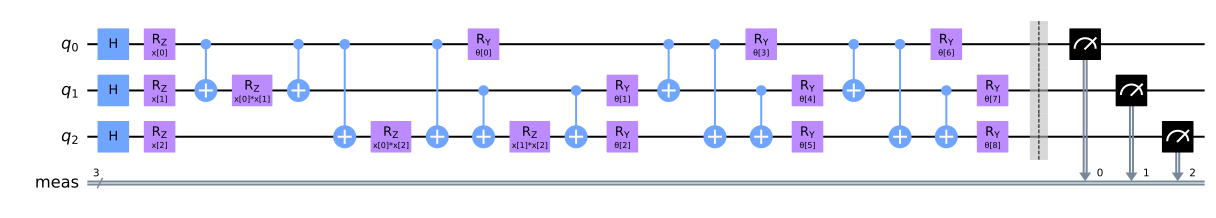

In [414]:
feature = QuantumCircuit(numq)
var     = QuantumCircuit(numq)

# feature encoding
for q in range(numq):
    feature.h(q)

for i in range(numx):
    feature.rz(x[i], i)

for l in range(numx-1):
    for i in range(l+1, numx):
        feature.cx(l, i)
        feature.rz(x[l]*x[i], i)
        feature.cx(l, i)

# variational encoding
variational = EfficientSU2(num_qubits=numq, su2_gates='ry', entanglement='full',
                           reps=num_layers, parameter_prefix='θ')
numtheta    = variational.num_parameters
theta       = ParameterVector('θ', numtheta)
variational.assign_parameters(theta, inplace=True)
variational = variational.decompose()

# model
model = feature.compose(variational)
model.measure_all()
model.draw()

In [415]:
def eval_model(device, shots, input, params):
    theta_    = params[:numtheta]
    weights   = params[numtheta:]
    weights   = np.reshape(weights, (num_out, num_in)) 
    
    instance  = model.bind_parameters({x: input, theta: theta_})

    results   = device.run(instance, shots=shots).result()
    counts    = results.get_counts()
    countsvec = np.zeros((num_in))
    
    normf     = sum(counts.values())
    for key, value in counts.items():
        idx            = int(key, 2)
        countsvec[idx] = float(value)/float(normf) 

    EX    = weights**2 @ countsvec
    VarEX = (weights**2-EX[0])**2 @ countsvec

    return EX, VarEX

In [416]:
seed = 0
rng  = np.random.default_rng(seed=seed)

samplex     = rng.uniform(low=-2*pi, high=2*pi,  size=numx)
sampletheta = rng.uniform(low=-2*pi, high=2*pi,  size=numtheta)
weights_    = rng.uniform(low=-1., high=1.,  size=num_out*num_in)

params      = np.concatenate((sampletheta, weights_))

In [ ]:
# hand picked data
data       = [[0.1, 0.2, 15.], [0.5, 0.8, 100.]]
labels     = [[0.22], [16.]]

In [448]:
# read in geodict data
file   = '/home/test/Research/QC/geodict-ml-data/geodict-ml-data/train_data/sphere_train.csv'
data   = np.genfromtxt(file, delimiter=',')
input  = data[:, 0:3]
labels = data[:, -1]
labels = labels[..., np.newaxis]

In [459]:
input_min   = [0., 0., 0.]
input_max   = [0.52, 1000., 1000.]
labels_min  = [0.]
labels_max  = [1000.]

# normalize data
scaler      = MinMaxScaler()
#scaler.fit([input_min, input_max])
input_norm   = scaler.fit_transform(input)
#scaler.fit([labels_min, labels_max])
labels_norm = scaler.fit_transform(labels)

print(input[-3:-1])
print(input_norm[-3:-1])
print(labels[-3:-1])
print(labels_norm[-3:-1])

[[3.76823921e-01 9.35239626e+02 3.65727290e+02]
 [2.37338939e-01 7.24142514e+02 1.58789918e+02]]
[[0.72039393 0.938862   0.36604352]
 [0.44401341 0.72683979 0.15670856]]
[[365.7272896]
 [158.7899179]]
[[0.36604352]
 [0.15670856]]
0.06544984694978735
99.77036792450339


In [418]:
device = AerSimulator()
shots  = 10000
out    = eval_model(device, shots, data_norm[0], params)
print(out)

(array([0.50246108]), array([0.09685989]))


In [419]:
# MSE (normalized)
lam  = 0.05
M    = len(labels_norm)
def cost(params):

    C = 0.
    for m in range(M):
        EX, VarX = eval_model(device, shots, data_norm[m], params)
        error    = labels_norm[m][0] - EX[0]
        error    = np.inner(error, error)/np.inner(labels_norm[m], labels_norm[m])
        C       += error + lam*VarX[0]

    C /= M

    return C

def av_error(params):

    C = 0.
    for m in range(M):
        EX, _ = eval_model(device, shots, data_norm[m], params)
        error = labels_norm[m][0] - EX[0]
        error = abs(error)/abs(labels_norm[m][0])
        C    += error

    C /= M

    return C

In [420]:
m = 1
cost(params)
EX, VarX = eval_model(device, shots, data_norm[m], params)
print(EX, VarX)
error = labels_norm[m][0] - EX[0]
print(error)
error    = np.inner(error, error)/np.inner(labels_norm[m], labels_norm[m])
print(error)

[0.4935338] [0.0920052]
-0.4775337959478383
890.7754932513737


In [368]:
energy = []
sizes  = []
def callback(nev, x, fval, h, accept):
    energy.append(fval)
    sizes.append(abs(max(x)))

spsa          = SPSA(maxiter=300, callback=callback)
initial_point = params
result        = spsa.minimize(cost, initial_point)

In [421]:
energy = []
sizes  = []
def callback(x):
    energy.append(cost(x))
    sizes.append(abs(max(x)))

powell        = POWELL(maxiter=10, maxfev=3000, dispt=True, callback=callback)
initial_point = params
result        = powell.minimize(cost, initial_point)

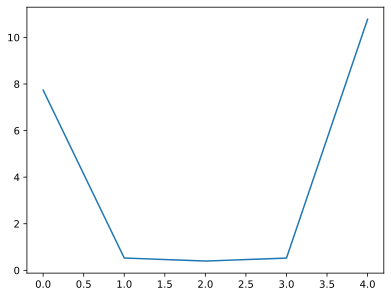

In [422]:
plt.plot(energy)

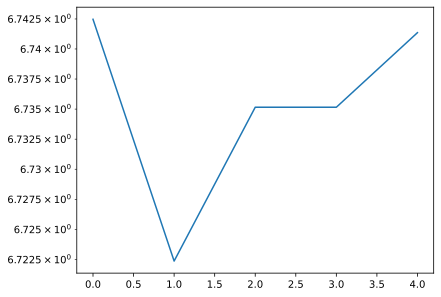

In [423]:
plt.semilogy(sizes)

In [431]:
opt_params = result.x
predict    = [eval_model(device, shots, data_norm[m], opt_params) for m in range(M)]
print(labels_norm)
print(predict)
print(cost(opt_params))
print(av_error(opt_params))

[[0.00022]
 [0.016  ]]
[(array([0.001394]), array([0.00282498])), (array([0.00521093]), array([0.00699528]))]
25.039232655516077
2.19955474539463
